<a href="https://www.kaggle.com/code/justiceopoku/ar-model-for-electricity-price-forecasting?scriptVersionId=268383095" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Abstract
This project analyzes and forecasts the monthly U.S. electricity price index using historical data from the Bureau of Labor Statistics (BLS) Consumer Price Index (Electricity per KWH in U.S. city average, average price, not seasonally adjusted). By applying classical time series modeling with autoregressive (AR) models, the project captures temporal dependencies and seasonal patterns in electricity prices from 2010 to 2025. A rolling forecast approach is employed, splitting the data into training and testing sets to generate out-of-sample predictions, achieving an accuracy of over 90% based on evaluation metrics such as RMSE and MAPE. The model is then used to predict electricity prices for the next 24 months, estimating an average price of $0.199 per KWH. Visualizations compare observed, cross-validated, and forecasted values, providing clear insights into expected trends for both data enthusiasts and energy market stakeholders.

In [1]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import ar_select_order
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

### Loading dataset

In [2]:
df_full = pd.read_csv("/kaggle/input/electricity-per-kwh-in-u-s/electricity_prices.csv")

## Overview of the data

In [3]:
print(df_full.head())
print()
print(df_full.tail())

      Series ID  Year Period     Label  Value
0  APU000072610  2010    M01  2010 Jan  0.124
1  APU000072610  2010    M02  2010 Feb  0.123
2  APU000072610  2010    M03  2010 Mar  0.125
3  APU000072610  2010    M04  2010 Apr  0.126
4  APU000072610  2010    M05  2010 May  0.127

        Series ID  Year Period     Label  Value
183  APU000072610  2025    M04  2025 Apr  0.181
184  APU000072610  2025    M05  2025 May  0.182
185  APU000072610  2025    M06  2025 Jun  0.190
186  APU000072610  2025    M07  2025 Jul  0.189
187  APU000072610  2025    M08  2025 Aug  0.190


## Preprocess Data

The data preprocessing cleans and prepares the electricity price dataset for time series analysis. Annual averages (M13) are removed, and the "Value" column is converted to numeric. The year and month are extracted to create a proper datetime column "Date", which is then set as the DataFrame index. Finally, the "Value" column is renamed "Electricity_price" and selected as the time series for analysis.

In [4]:
df_full = df_full[df_full["Period"] != "M13"]  # remove annual averages
df_full["Value"] = pd.to_numeric(df_full["Value"], errors="coerce")  # convert to numeric
df_full["Year"] = df_full["Year"].astype(int)  # ensure Year is integer
df_full["Month"] = df_full["Period"].str.extract(r"M(\d+)").astype(int)  # extract month number
df_full["Date"] = pd.to_datetime(dict(year=df_full["Year"], month=df_full["Month"], day=1))  # create datetime
df_full = df_full.sort_values("Date").reset_index(drop=True)  # sort by date
df_full.rename(columns={"Value": "Electricity_price"}, inplace=True)  # rename column
df_full.set_index("Date", inplace=True)  # set Date as index

# Select the column for time series
series = df_full[["Electricity_price"]]


## Split Data: Training / Testing

The dataset is split into training and testing sets, with 70% of the data used for training (historic) and the remaining 30% reserved for testing (test). An empty list predictions is initialized to store forecasted values.

In [5]:
train_size = int(len(series) * 0.7)
historic = series.iloc[:train_size]["Electricity_price"].tolist()
test = series.iloc[train_size:]

predictions = []

## Rolling Forecast (Cross-validation)

A rolling forecast is performed on the test set using autoregressive (AR) modeling. For each step, the optimal lag order is selected, the AR model is fitted on the current historical data, and the next value is predicted. The prediction is stored, and the actual test value is appended to the history. Finally, all predictions are compiled into a series aligned with the test set index.

In [6]:
for i in range(len(test)):
    sel = ar_select_order(historic, maxlag=13, old_names=False)
    model_fit = sel.model.fit()
    pred = model_fit.predict(start=len(historic),
                             end=len(historic), dynamic=False)
    predictions.append(pred[0])
    historic.append(float(test.iloc[i]["Electricity_price"]))

cross_val = pd.Series(predictions, index=test.index)

## Evaluating Model Performance

The model’s forecasting performance is evaluated using RMSE (root mean squared error) and MAPE (mean absolute percentage error). The metrics are calculated by comparing the predicted values (cross_val) with the actual test values, and the results are printed.

In [7]:
rmse = mean_squared_error(test["Electricity_price"],
                          cross_val, squared=False)
mape = mean_absolute_percentage_error(test["Electricity_price"],
                                      cross_val) * 100

print("Test RMSE:", round(rmse,5))
print("Test MAPE (%):", round(mape*100,2))

Test RMSE: 0.00198
Test MAPE (%): 90.18


## Forecast Next 24 Months

he next 24 months are prepared for forecasting by creating a future date range starting from the month after the last observation in the series. This range (date_pred) will serve as the index for predicted values.

In [8]:
n_pred = 24
last_date = series.index[-1]
date_pred = pd.date_range(start=last_date +
                          pd.offsets.MonthBegin(1), periods=n_pred, freq="MS")

## Fit model on full data

The AR model is fitted on the full dataset to leverage all available historical electricity prices. The optimal lag order is selected, and the final autoregressive model is trained on the complete series for forecasting future values.

In [9]:
historic_full = series["Electricity_price"].tolist()
sel_full = ar_select_order(historic_full, maxlag=13, old_names=False)
model_fit_full = sel_full.model.fit()

## Forecast Future Average Electricity Prices

Future electricity prices are predicted for the next 24 months using the AR model fitted on the full dataset. The predicted values are stored in a series with corresponding future dates, and approximate 95% confidence intervals are calculated using the standard deviation of the model residuals.

In [10]:
pred_future = model_fit_full.predict(start=len(historic_full), end=len(historic_full) + n_pred - 1, dynamic=False)
pred_mean = pd.Series(pred_future, index=date_pred)

# Approximate 95% CI using residual std
resid_std = np.std(model_fit_full.resid)
conf_lower = pred_mean - 1.96 * resid_std
conf_upper = pred_mean + 1.96 * resid_std

### Plot Observed, Cross-validated, Forecast

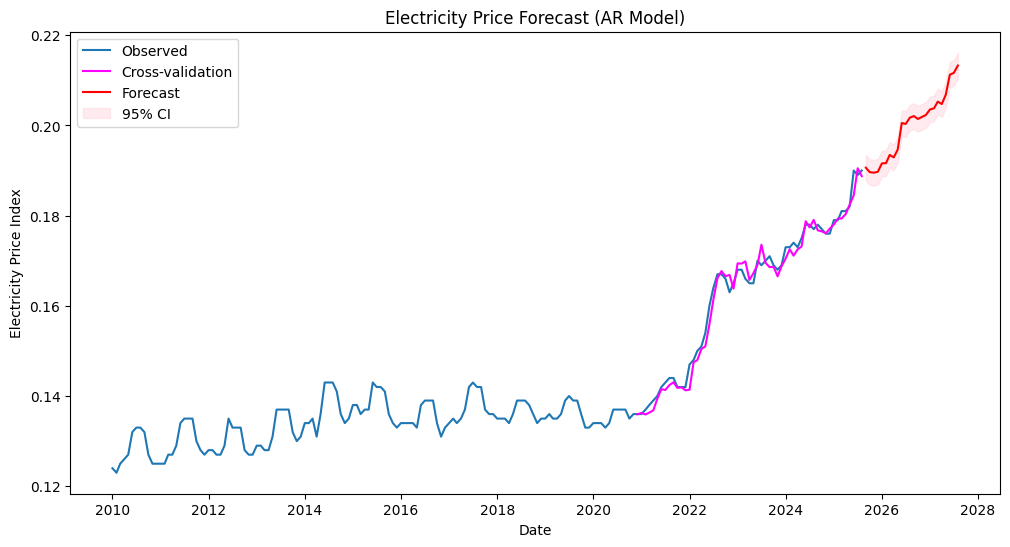

In [11]:
plt.figure(figsize=(12,6))
plt.plot(series, label="Observed")
plt.plot(cross_val, color="magenta", label="Cross-validation")
plt.plot(pred_mean, color="red", label="Forecast")
plt.fill_between(date_pred, conf_lower, conf_upper, color="pink", alpha=0.3, label="95% CI")
plt.title("Electricity Price Forecast (AR Model)")
plt.xlabel("Date")
plt.ylabel("Electricity Price Index")
plt.legend()
plt.show()

### Summary of Forecast

In [12]:
print("Forecasted average electricity price (next 24 months):",
      round(pred_mean.mean(), 3))

Forecasted average electricity price (next 24 months): 0.2
